In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
DATAROOT = r'./data/'
wine_data = dict(
    red='winequality-red.csv',
    white='winequality-white.csv'
)
wine_data = dict(
    red=pd.read_csv(
        DATAROOT + wine_data['red'], 
        sep=';'
    ).to_numpy(),
    white=pd.read_csv(
        DATAROOT + wine_data['white'], 
        sep=';'
    ).to_numpy()
)

In [3]:
def PCA(data, n):
    mean = np.average(data, axis=0)
    S = np.sum([
        np.outer(x - mean, x - mean)
        for x in data
    ], axis=0)
    v, w = np.linalg.eig(S)
    reduced_data = np.concatenate([
        np.dot(w[:, 0:n].T, x - mean)[np.newaxis, :]
        for x in data
    ], axis=0)
    return reduced_data

In [12]:
def LDA(data, label, n, c, epsilon=0.001):
    data_sep = [
        data[np.where(label == i)]
        for i in range(c)
    ]
    mean_t = np.average(data, axis=0)
    mean_sep = [
        np.average(data_i, axis=0)
        for data_i in data_sep
    ]
    Sw = list()
    for data_i, mean_i in zip(data_sep, mean_sep):
        for x in data_i:
            Sw.append(np.outer(
                (x - mean_i), 
                (x - mean_i)
            ))
    Sw = np.sum(Sw, axis=0)
    Sb = np.sum([
        len(data_i) * np.outer(
            (mean_i - mean_t), 
            (mean_i - mean_t)
        )
        for data_i, mean_i in zip(data_sep, mean_sep)
    ], axis=0)
    if np.linalg.matrix_rank(Sw) == Sw.shape[0]:
        Sw = Sw + epsilon * np.eye(Sw.shape[0])
    S = np.linalg.inv(Sw) @ Sb
    v, w = np.linalg.eig(S)
    v = v.astype(dtype=np.float32)
    w = w.astype(dtype=np.float32)
    reduced_data = np.concatenate([
        np.dot(w[:, 0:n].T, x - mean_t)[np.newaxis, :]
        for x in data
    ], axis=0)
    return reduced_data

In [5]:
data = dict(
    red=wine_data['red'][:, 0:-1], 
    white=wine_data['white'][:, 0:-1]
)
label = dict(
    red=wine_data['red'][:, -1], 
    white=wine_data['white'][:, -1]
)
label['red'] -= np.min(label['red'])
label['white'] -= np.min(label['white'])
c = dict(
    red=len(set(label['red'])), 
    white=len(set(label['white']))
)

/tmp/ipykernel_13905/2170154801.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


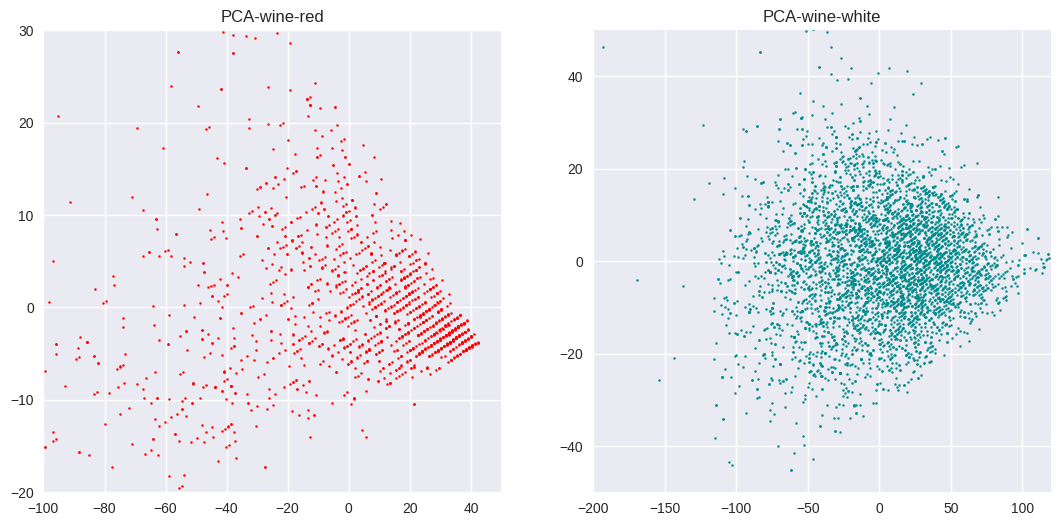

In [6]:
reduced_data = dict(
    red=PCA(data['red'], 2), 
    white=PCA(data['white'], 2)
)
plt.style.use('seaborn')
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].set_title('PCA-wine-red')
axs[1].set_title('PCA-wine-white')
axs[0].set_xlim(-100, 50)
axs[0].set_ylim(-20, 30)
axs[1].set_xlim(-200, 120)
axs[1].set_ylim(-50, 50)
axs[0].scatter(
    reduced_data['red'][:, 0], 
    reduced_data['red'][:, 1], 
    s=2, c='red'
)
axs[1].scatter(
    reduced_data['white'][:, 0], 
    reduced_data['white'][:, 1], 
    s=2, c='darkcyan'
)
plt.show()

In [7]:
from sklearn.discriminant_analysis import\
LinearDiscriminantAnalysis as sk_LDA
sk_LDA_model = dict()
sk_LDA_model['red'] = sk_LDA('eigen', n_components=2)
sk_LDA_model['white'] = sk_LDA('eigen', n_components=2)
sk_LDA_model['red'].fit(data['red'], label['red'])
sk_LDA_model['white'].fit(data['white'], label['white'])

LinearDiscriminantAnalysis(n_components=2, solver='eigen')

/tmp/ipykernel_16582/1391353715.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('hot')
/tmp/ipykernel_16582/1391353715.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(
/tmp/ipykernel_16582/1391353715.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify t

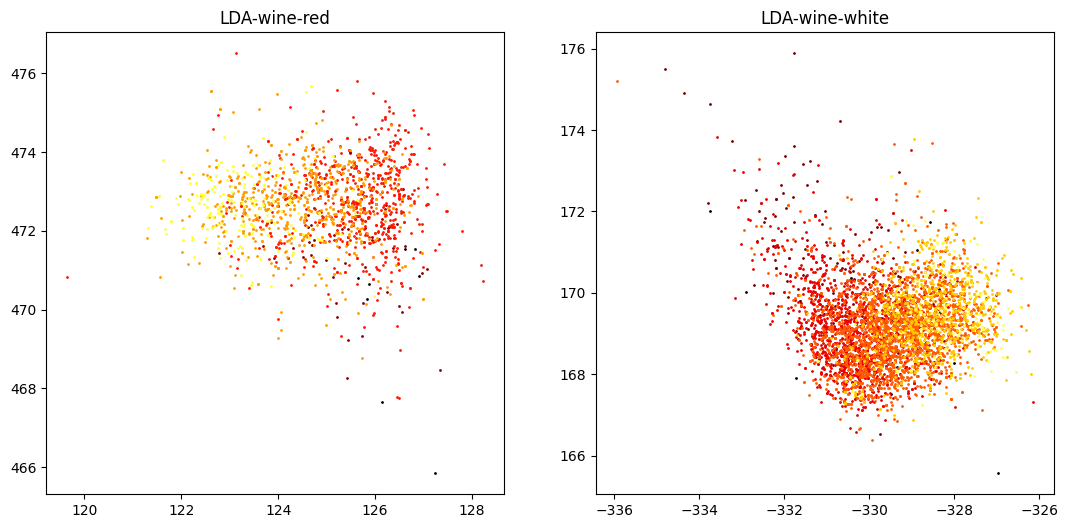

In [8]:
reduced_data = dict(
    red=sk_LDA_model['red'].transform(data['red']), 
    white=sk_LDA_model['white'].transform(data['white'])
)
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].set_title('LDA-wine-red')
axs[1].set_title('LDA-wine-white')
'''
axs[0].set_xlim(-0.06, 0.04)
axs[0].set_ylim(-0.01, 0.02)
axs[1].set_xlim(-0.015, 0.015)
axs[1].set_ylim(-0.04, 0.03)
'''
colors = cm.get_cmap('hot')
color = dict()
color['red'] = colors(np.linspace(0, 1, c['red']))
color['white'] = colors(np.linspace(0, 1, c['white']))

for i in range(c['red']):
    data_i = reduced_data['red'][
        np.where(label['red'] == i)
    ]
    axs[0].scatter(
        data_i[:, 0], 
        data_i[:, 1], 
        s=1, c=color['red'][i]
    )
for i in range(c['white']):
    data_i = reduced_data['white'][
        np.where(label['white'] == i)
    ]
    axs[1].scatter(
        data_i[:, 0], 
        data_i[:, 1], 
        s=1, c=color['white'][i]
    )
plt.show()

/tmp/ipykernel_16582/3040790390.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  v = v.astype(dtype=np.float32)
/tmp/ipykernel_16582/3040790390.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  w = w.astype(dtype=np.float32)
/tmp/ipykernel_16582/1663773593.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('hot')
/tmp/ipykernel_16582/1663773593.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0].scatter(
/tmp/ipykernel_16582/1663773593.p

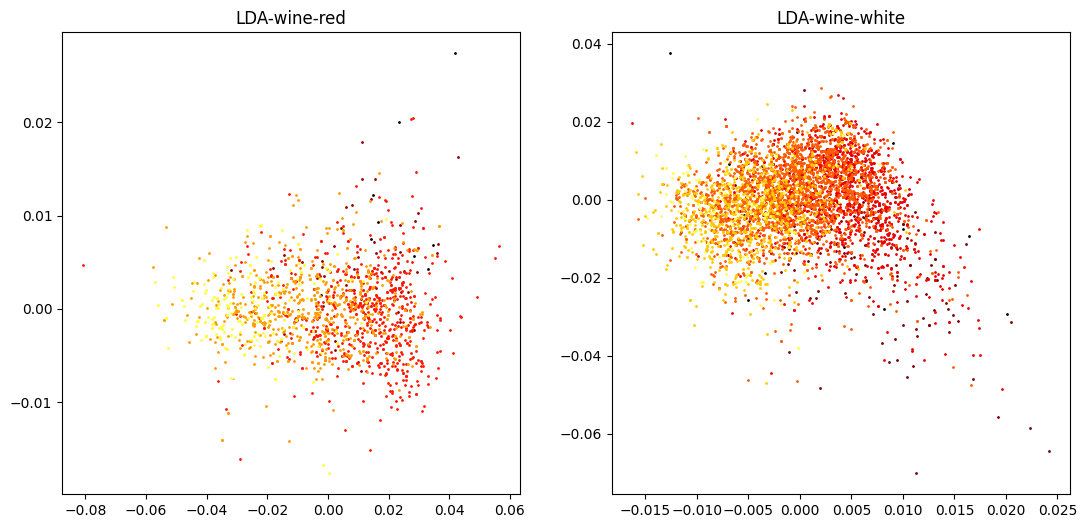

In [25]:
reduced_data = dict(
    red=LDA(
        data['red'], 
        label['red'], 
        2, c['red']
    ), 
    white=LDA(
        data['white'], 
        label['white'], 
        2, c['white']
    )
)
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].set_title('LDA-wine-red')
axs[1].set_title('LDA-wine-white')
'''
axs[0].set_xlim(-0.06, 0.04)
axs[0].set_ylim(-0.01, 0.02)
axs[1].set_xlim(-0.015, 0.015)
axs[1].set_ylim(-0.04, 0.03)
'''
colors = cm.get_cmap('hot')
color = dict()
color['red'] = colors(np.linspace(0, 1, c['red']))
color['white'] = colors(np.linspace(0, 1, c['white']))

for i in range(c['red']):
    data_i = reduced_data['red'][
        np.where(label['red'] == i)
    ]
    axs[0].scatter(
        data_i[:, 0], 
        data_i[:, 1], 
        s=1, c=color['red'][i]
    )
for i in range(c['white']):
    data_i = reduced_data['white'][
        np.where(label['white'] == i)
    ]
    axs[1].scatter(
        data_i[:, 0], 
        data_i[:, 1], 
        s=1, c=color['white'][i]
    )
plt.show()

In [6]:
class LogisticRegression:

    def __init__(self):
        self.w = None
    
    def fit(
            self, 
            w0, 
            data, 
            label, 
            lr, 
            iterations
    ):
        self.w = w0
        data = np.concatenate([
            data, np.ones(data.shape[0], 1)
        ])
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        for i in range(iterations):
            grad = np.sum([
                (-y + sigmoid(np.dot(self.w, x))) * x
                for x, y in zip(data, label)
            ])
            self.w -= lr * grad
    
    def predict(self, x):
        pred = np.dot(self.w, x)
        return 1 if pred > 1 else 0